In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

## Getting the data

To get the data, either run `gather.py` located in root folder, or add the data manually to the `data` folder.

## Optimization:

### Currently, all yearly dataset consume a lot of memory:
**for example, 1987 alone weighs 484 MB.**

1. convert yearly csv files to feather files for faster loading time.

2. convert relevant columns to categorical(done by `get_years` function in `load.py` module). Also assists with loading time from feather.

### *NOTE - initally planned to just use unsampled datasets, but visualization operations are taking way too long.*

3. sample each year seperately, then concatenate selected years, then sample again.

In [2]:
from load import get_years, wipe_frames
#More info and demonstration within module.

In [3]:
df = get_years(year_range=(2000, 2008))

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   UniqueCarrier      9000 non-null   category
 1   Year               9000 non-null   category
 2   Month              9000 non-null   category
 3   DayOfMonth         9000 non-null   category
 4   DayOfWeek          9000 non-null   category
 5   Cancelled          9000 non-null   boolean 
 6   ArrDelay           8764 non-null   float32 
 7   DepDelay           8784 non-null   float32 
 8   Diverted           9000 non-null   boolean 
 9   Origin             9000 non-null   category
 10  Dest               9000 non-null   category
 11  ActualElapsedTime  8764 non-null   float32 
 12  AirTime            8764 non-null   float32 
 13  Distance           9000 non-null   float32 
 14  route              9000 non-null   category
dtypes: boolean(2), category(8), float32(5)
memory usage: 41

## Exploration

In [5]:
def drop_outliers(data, value_col, p=5, category_col=None):
    """Return DataFrame without overflow values."""
    def trunc(frame):  
        top, bottom = np.nanpercentile(a=frame[value_col], q=[100 - p / 2, p / 2])
        return frame[(frame[value_col] >= bottom) & (frame[value_col] <= top)].copy()
    if category_col:
        if data[category_col].dtype != 'category':
            raise TypeError('Category_col dtype should be categorical.')
        objs = [trunc(data[data[category_col] == item]) for item in data[category_col].cat.categories]
        return pd.concat(objs, ignore_index=True)
    else:
        return trunc(data)

In [6]:
df = get_years(year_range=(2000, 2008)) # loads about ~3mins, but final dataset is very light.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   UniqueCarrier      9000 non-null   category
 1   Year               9000 non-null   category
 2   Month              9000 non-null   category
 3   DayOfMonth         9000 non-null   category
 4   DayOfWeek          9000 non-null   category
 5   Cancelled          9000 non-null   boolean 
 6   ArrDelay           8780 non-null   float32 
 7   DepDelay           8799 non-null   float32 
 8   Diverted           9000 non-null   boolean 
 9   Origin             9000 non-null   category
 10  Dest               9000 non-null   category
 11  ActualElapsedTime  8780 non-null   float32 
 12  AirTime            8780 non-null   float32 
 13  Distance           9000 non-null   float32 
 14  route              9000 non-null   category
dtypes: boolean(2), category(8), float32(5)
memory usage: 41

In [8]:
def drop_outliers(data, value_col, p=5, category_col=None):
    """Return DataFrame without overflow values."""
    def trunc(frame):  
        top, bottom = np.nanpercentile(a=frame[value_col], q=[100 - p / 2, p / 2])
        return frame[(frame[value_col] >= bottom) & (frame[value_col] <= top)].copy()
    if category_col:
        if data[category_col].dtype != 'category':
            raise TypeError('Category_col dtype should be categorical.')
        objs = [trunc(data[data[category_col] == item]) for item in data[category_col].cat.categories]
        return pd.concat(objs, ignore_index=True)
    else:
        return trunc(data)

### 1. Distribution of departure delays in for each carrier in 2000-2008(95% of data)

<AxesSubplot: xlabel='UniqueCarrier', ylabel='DepDelay'>

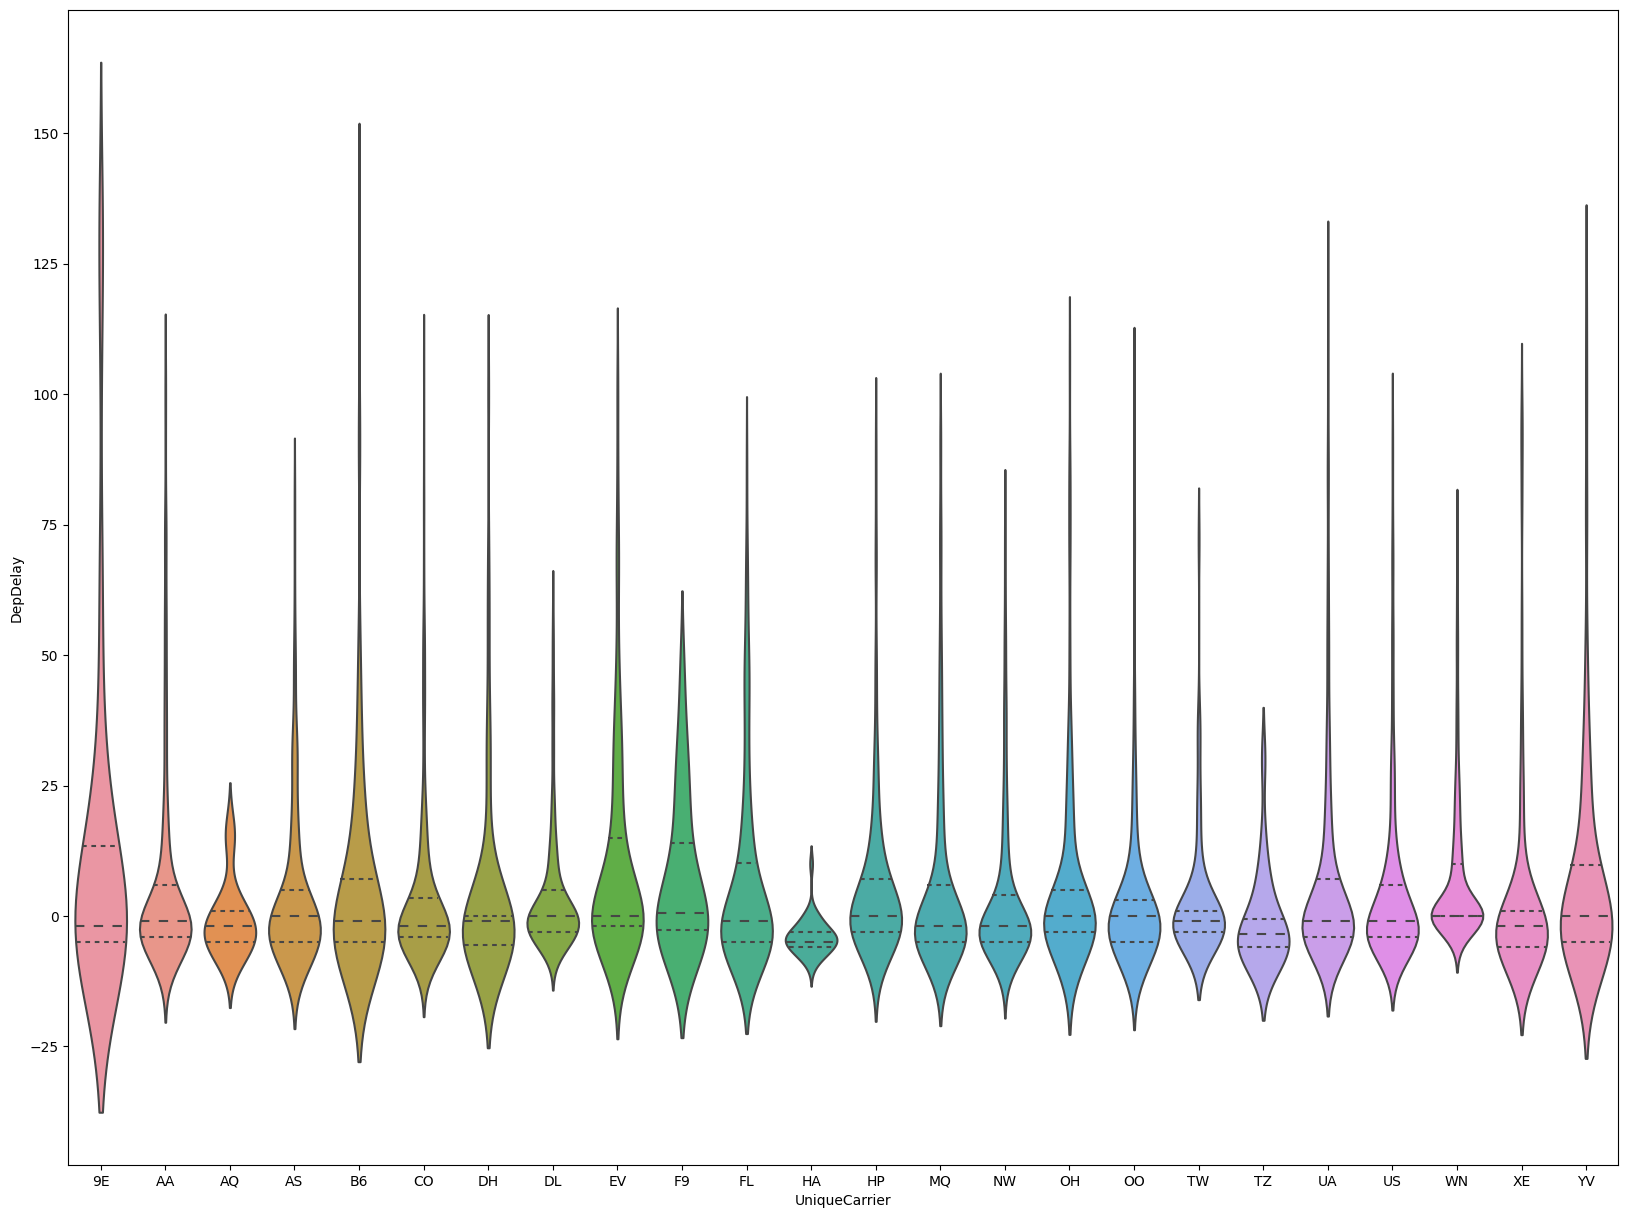

In [9]:
fig = plt.figure(figsize=(20, 15))
chart_data = drop_outliers(df, value_col='DepDelay', category_col='UniqueCarrier')
sns.violinplot(data=chart_data, x='UniqueCarrier', y='DepDelay', inner='quartile', scale='width')

### 2. Distribution of departure delay combined with arrival delay (%95 of data)

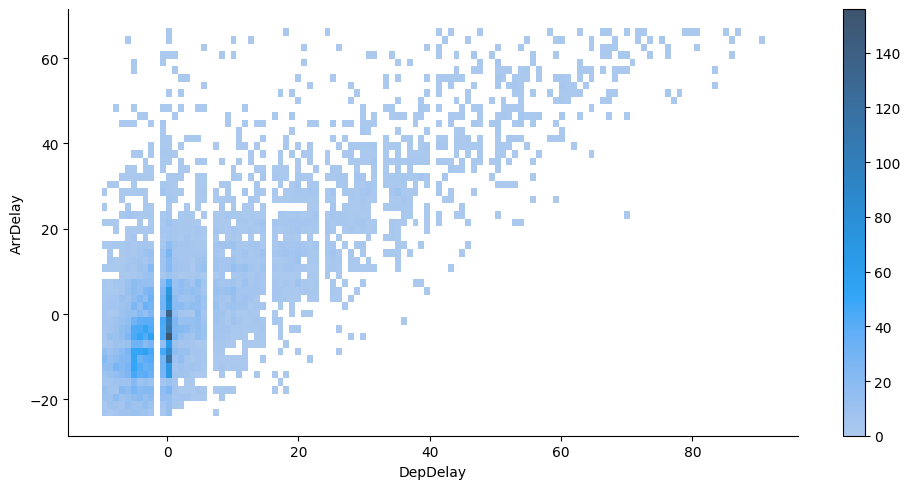

In [10]:
chart_data = drop_outliers(drop_outliers(df, 'DepDelay'), 'ArrDelay')
sns.displot(data=chart_data, x='DepDelay', y='ArrDelay', cbar=True, aspect=2)

### 3. Most common routes

<BarContainer object of 10 artists>

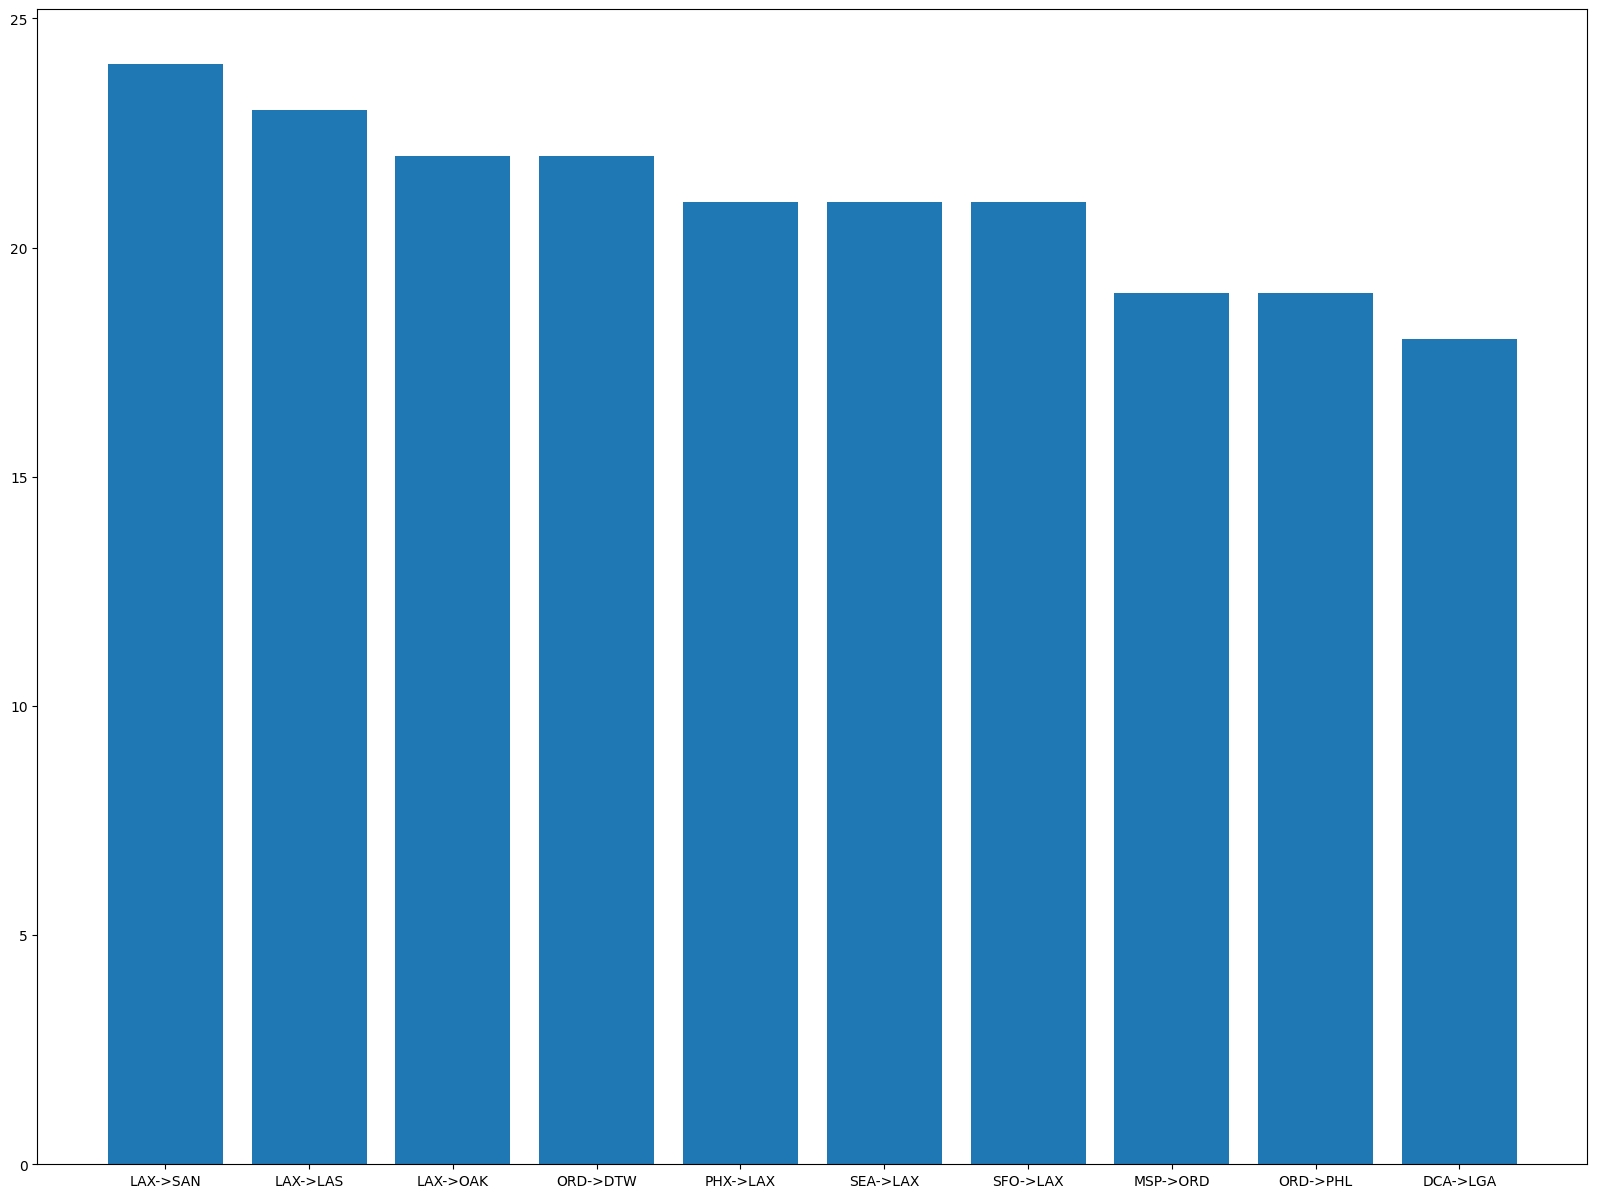

In [11]:
fig = plt.figure(figsize=(20, 15))
routes = df.groupby('route', as_index=False).size()
chart_data = routes.nlargest(n=10, columns='size')
plt.bar(x=chart_data['route'], height=chart_data['size'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   UniqueCarrier      9000 non-null   category
 1   Year               9000 non-null   category
 2   Month              9000 non-null   category
 3   DayOfMonth         9000 non-null   category
 4   DayOfWeek          9000 non-null   category
 5   Cancelled          9000 non-null   boolean 
 6   ArrDelay           8780 non-null   float32 
 7   DepDelay           8799 non-null   float32 
 8   Diverted           9000 non-null   boolean 
 9   Origin             9000 non-null   category
 10  Dest               9000 non-null   category
 11  ActualElapsedTime  8780 non-null   float32 
 12  AirTime            8780 non-null   float32 
 13  Distance           9000 non-null   float32 
 14  route              9000 non-null   category
dtypes: boolean(2), category(8), float32(5)
memory usage: 41

### 4. yearly flight counts faceted by carrier

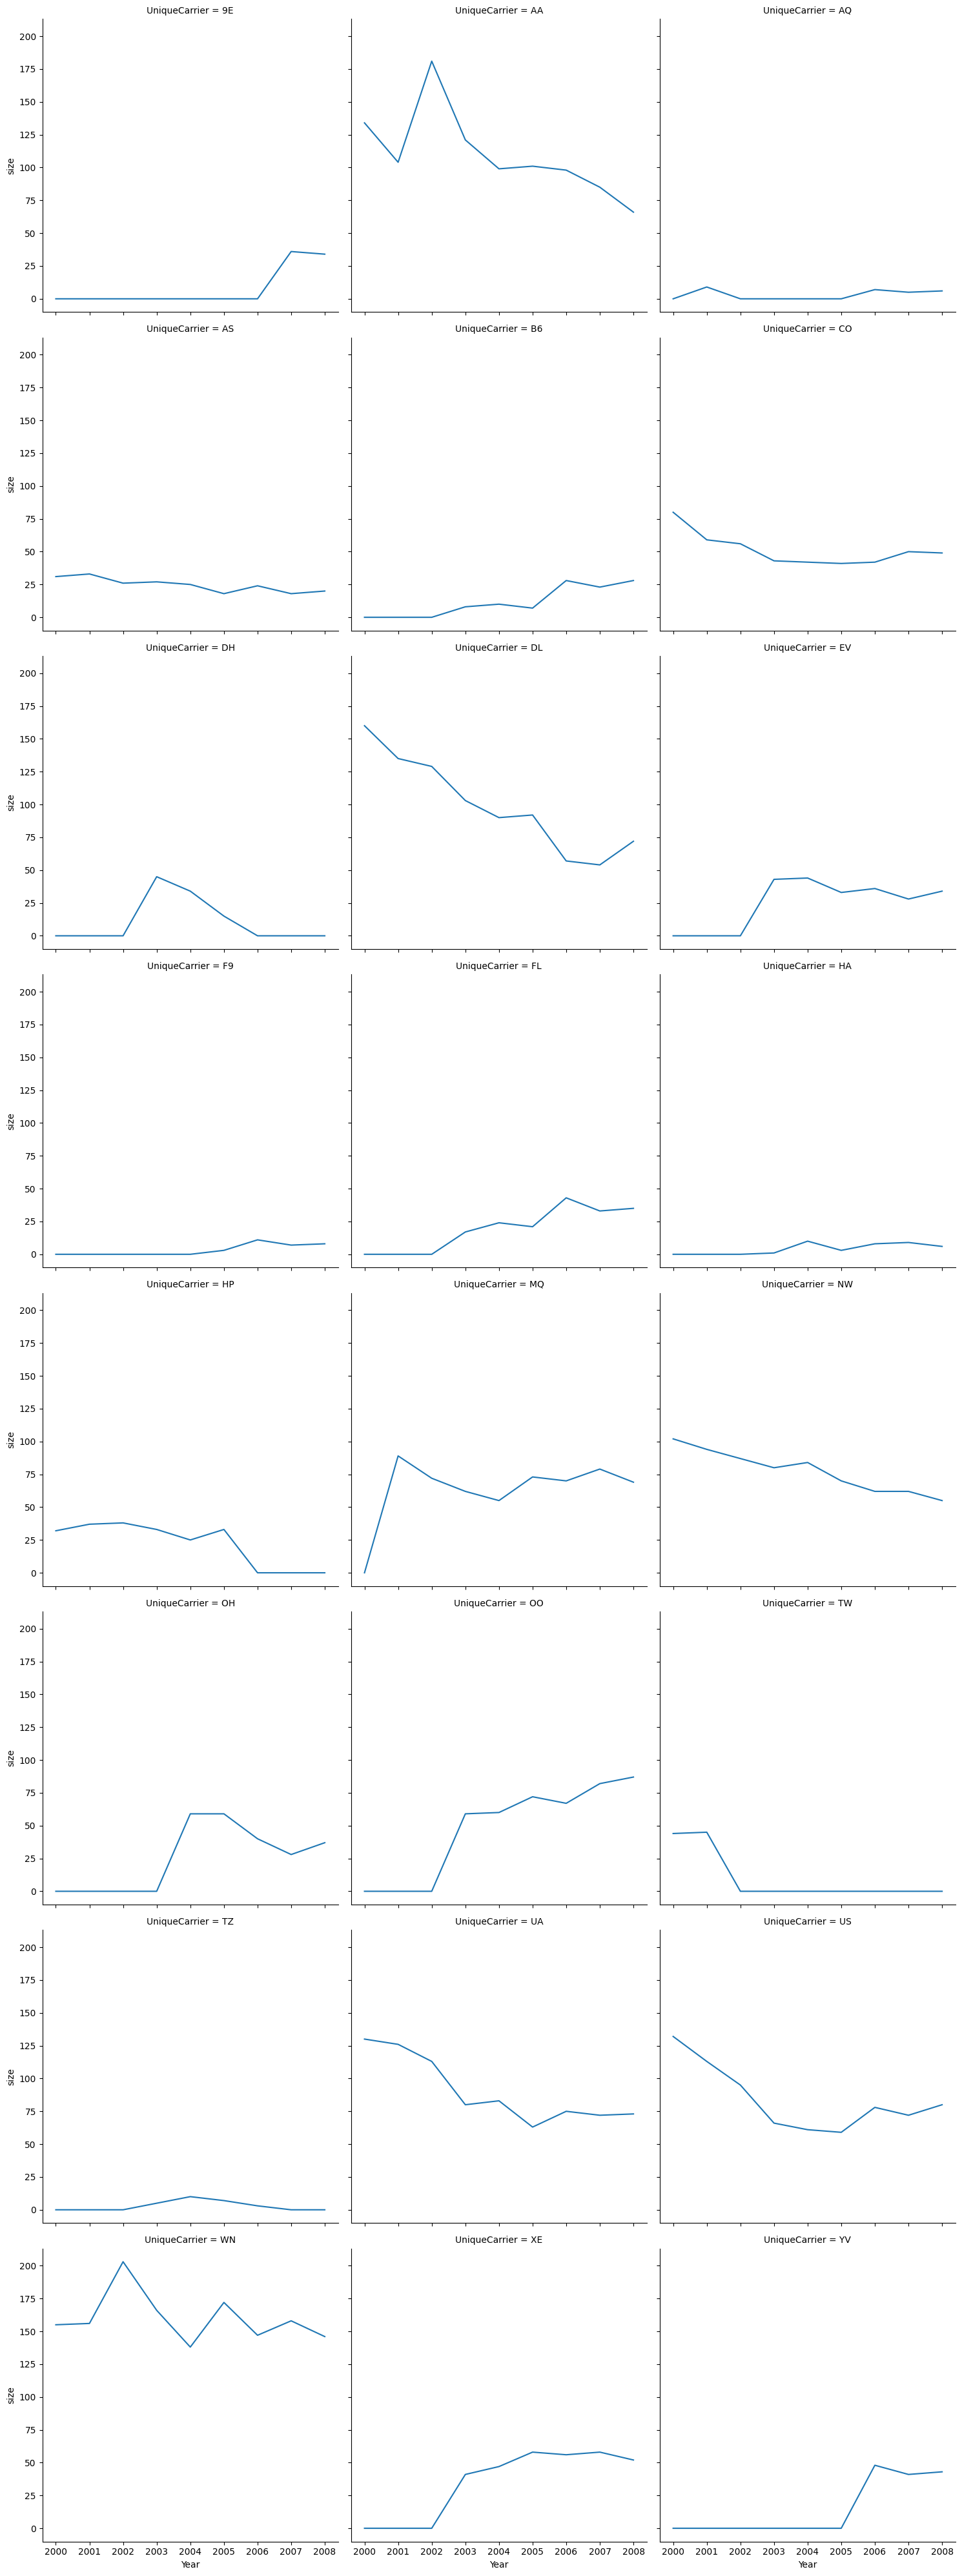

In [13]:
chart_data = df.groupby(['Year', 'UniqueCarrier'], as_index=False).size()
sns.relplot(data=chart_data, kind='line',x='Year',y='size', col='UniqueCarrier', col_wrap=3)

### 5. Month activity for each UniqueCarrier

<AxesSubplot: xlabel='Month', ylabel='UniqueCarrier'>

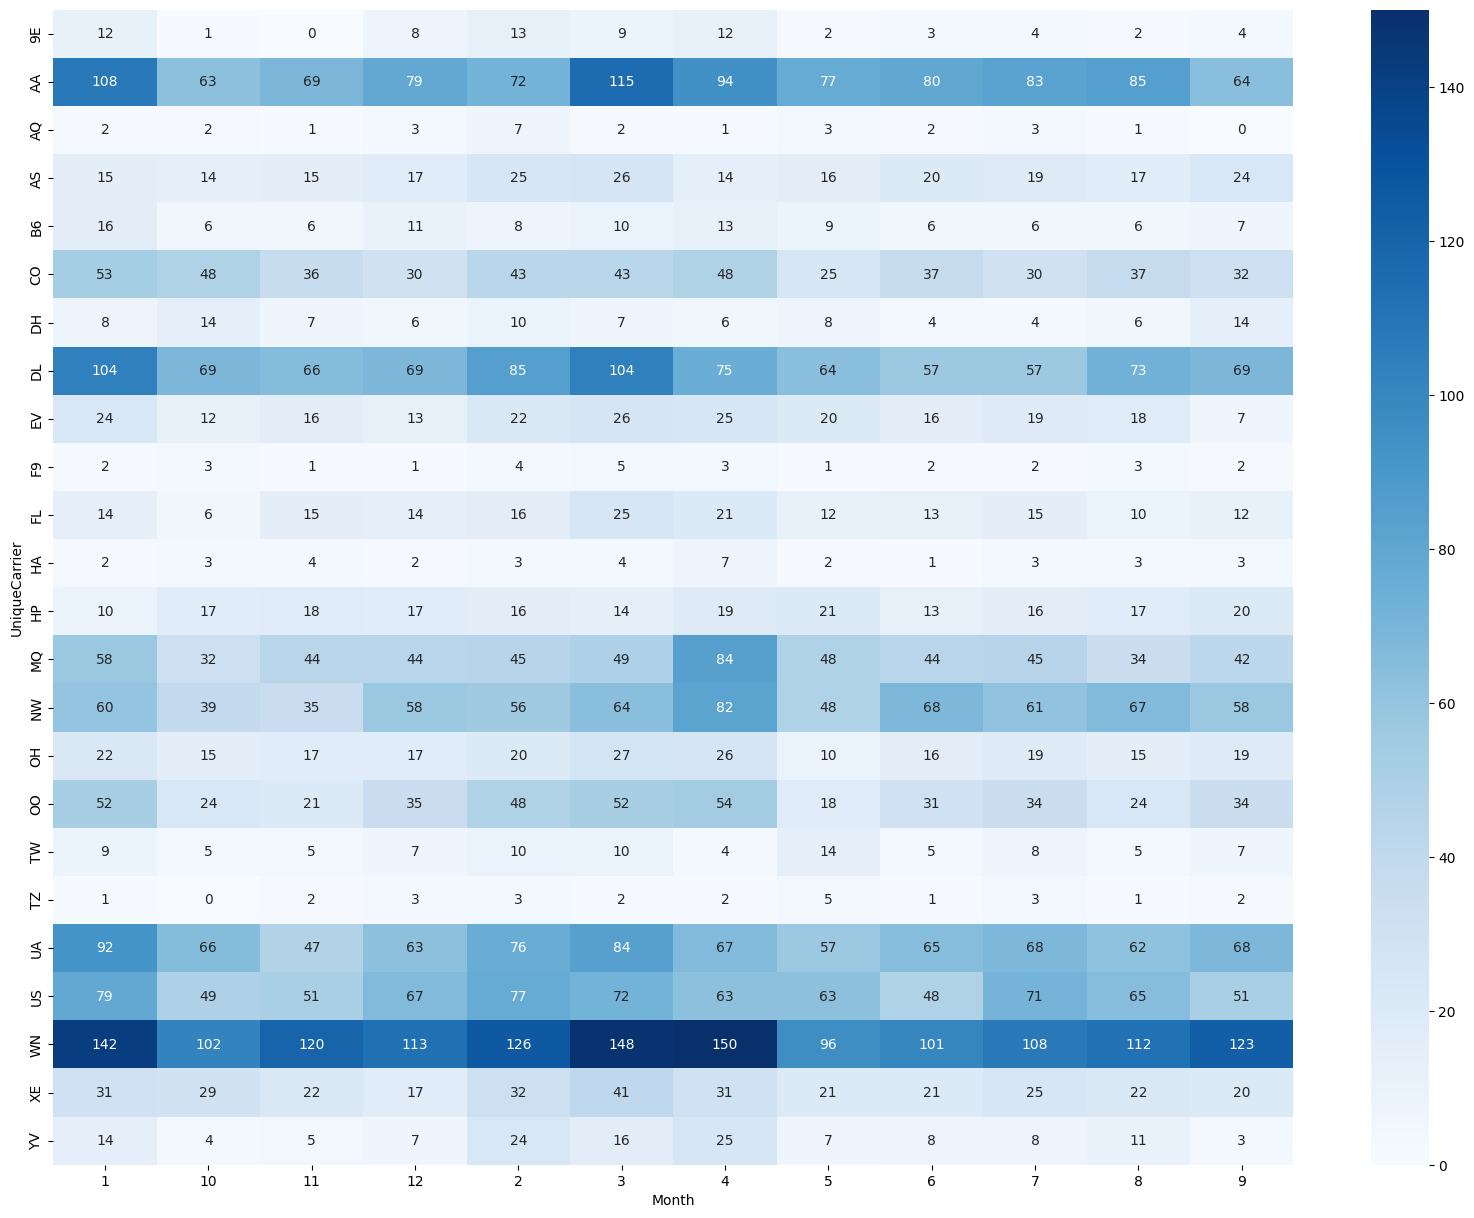

In [14]:
routes_cnts = df.groupby(by=['UniqueCarrier', 'Month'], as_index=False).size()
chart_data = routes_cnts.pivot(index='UniqueCarrier', columns='Month', values='size')
fig = plt.figure(figsize=(20, 15))
sns.heatmap(data=chart_data, annot=True, fmt=".0f", cmap='Blues')